# Devim, тестовое задание, Рассадин Ярослав

## Задача №1. Витрина данных

Дана таблица заявок на кредит: id - номер заявки, created_date - время создания заявки, decision - решение по заявке, decision_date - время принятия решения, issued_sum - сумма выдачи, issued_date - время выдачи.

Решение по заявкам может быть принято быстро или занять какое-то время (заявка будет без решения на это время). Не все одобренные заявки становятся выданными, также время одобрения заявки и выдачи могут отличаться.

Задача: менеджмент хочет понимать, находятся ли бизнес-показатели в норме в течение дня (например на 14:00, 18:00 и т. д.) в сравнении с показателями за предыдущие дни. Показатели: кол-во заявок, уровень одобрения, очередь заявок без решения, уровень выдач, средняя выданная сумма. Нормой можно считать показатели за последние 20 дней.

Предложите визуализации (концептуально или на примере) для ответа на такой вопрос бизнеса и напишите sql (любой диалект), который подготовит данные для этой визуализации.


### Создание таблицы

```sql
CREATE TABLE applications (
    id SERIAL PRIMARY KEY,
    created_date TIMESTAMP,
    decision VARCHAR(20),
    decision_date TIMESTAMP,
    issued_sum DECIMAL(10,2),
    issued_date TIMESTAMP
);

INSERT INTO applications (created_date, decision, decision_date, issued_sum, issued_date)
VALUES
    ('2022-01-01 12:00:00', 'approved', '2022-01-01 15:21:00', 10000, '2022-01-01 18:21:00'),
    ('2022-01-01 13:00:00', 'approved', '2022-01-01 14:02:00', NULL, NULL),
    ('2022-01-01 14:00:00', 'reject', '2022-01-01 14:36:00', NULL, NULL),
    ('2022-01-01 16:30:00', NULL, NULL, NULL, NULL);

```

### Написание запроса для витрины данных

Перед написанием запроса стоит полностью удостовериться, что исполнитель правильно интерпретировал задачу заказчика, задав уточняющие вопросы, дабы избежать недопониманий и исправлений в дальнейшем. 

```sql
WITH daily_metrics AS (
  SELECT
    DATE_TRUNC('hour', created_date) AS date_time,
    DATE(created_date) AS date,
    COUNT(*) AS num_applications,
    SUM(CASE WHEN decision IS NOT NULL THEN 1 ELSE 0 END) AS num_decisions,
    SUM(CASE WHEN decision = 'approved' THEN 1 ELSE 0 END) AS num_approved,
    SUM(CASE WHEN decision = 'reject' THEN 1 ELSE 0 END) AS num_declined,
    SUM(CASE WHEN decision IS NULL THEN 1 ELSE 0 END) AS num_pending,
    SUM(CASE WHEN issued_sum IS NOT NULL THEN 1 ELSE 0 END) AS num_issued,
    AVG(COALESCE(issued_sum, 0)) AS avg_issued_amount
  FROM
    applications
  GROUP BY
    date_time, date
),
last_20_days AS (
  SELECT
    *,
    AVG(num_applications) OVER (ORDER BY date_time DESC ROWS BETWEEN 19 PRECEDING AND CURRENT ROW) AS avg_num_applications_20d,
    AVG(num_approved) OVER (ORDER BY date_time DESC ROWS BETWEEN 19 PRECEDING AND CURRENT ROW) AS avg_num_approved_20d,
    AVG(num_pending) OVER (ORDER BY date_time DESC ROWS BETWEEN 19 PRECEDING AND CURRENT ROW) AS avg_num_pending_20d,
    AVG(num_issued) OVER (ORDER BY date_time DESC ROWS BETWEEN 19 PRECEDING AND CURRENT ROW) AS avg_num_issued_20d,
    AVG(avg_issued_amount) OVER (ORDER BY date_time DESC ROWS BETWEEN 19 PRECEDING AND CURRENT ROW) AS avg_issued_amount_20d
  FROM
    daily_metrics
)
SELECT
  date_time,
  date,
  num_applications,
  num_decisions,
  num_approved,
  num_declined,
  num_pending,
  num_issued,
  avg_issued_amount,
  avg_num_applications_20d,
  avg_num_approved_20d,
  avg_num_pending_20d,
  avg_num_issued_20d,
  avg_issued_amount_20d
FROM
  last_20_days
ORDER BY
  date_time DESC;
```

Для создания дашборда, который будет отвечать на запросы менеджмента, можно использовать следующий концептуальный подход.

Основываясь на представлении last_20_days, содержащем необходимые метрики, можно разработать интерактивный и информативный дашборд. Ключевым аспектом будет визуализация данных, позволяющая быстро оценивать текущее состояние бизнес-показателей и выявлять тренды.

Линейные графики могут отображать динамику основных метрик, таких как количество заявок, одобренных заявок, заявок в очереди и выданных займов, а также среднюю сумму выданных займов. Это поможет понять, как развивается ситуация в течение последних 20 дней.

Для сравнения с нормой можно использовать гистограммы или индикаторы, которые будут показывать текущее значение каждой метрики в сравнении со средним за тот же период. Это позволит быстро определить, находятся ли показатели в пределах ожидаемых значений.

Уровень одобрения заявок стоит выделить отдельно, например, в виде KPI-индикатора. Этот показатель характеризует эффективность процесса принятия решений.


## Задача №2. Исследование качества данных и анализ поведения клиентов с точки зрения просрочки платежей

Описание исследования:

Данное исследование было проведено с целью оценки качества данных и анализа характера поведения клиентов в отношении своевременности погашения платежей. 

Результаты исследования отражают текущее состояние качества данных и ситуацию с просроченными платежами, а также содержат рекомендации по дальнейшим действиям, направленным на улучшение качества данных и эффективное управление просроченной задолженностью.

### Загрузка данных и подготовка к анализу

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [2]:
payments, orders, plan = (
    pd.read_csv('payments.csv', 
                dtype={'order_id': 'int', 'paid_sum': 'float'}, 
                parse_dates=['paid_at']),
    
    pd.read_csv('orders.csv', 
                dtype={'order_id': 'int', 'issued_sum': 'float'},
                parse_dates=['created_at', 'put_at', 'closed_at']),
    
    pd.read_csv('plan.csv', dtype={'order_id': 'int', 'plan_sum_total': 'float'},
                parse_dates=['plan_at'])
)

#### Таблица payments

In [3]:
display(payments.head(5))

print(f"Данные доступны за период с {payments['paid_at'].min().date()} по {payments['paid_at'].max().date()}.")

,order_id,paid_at,paid_sum
0,400013633,2022-06-02 00:48:13.800,2500.0
1,400018480,2022-06-02 01:52:05.707,1070.0
2,400032001,2022-06-02 04:55:40.307,4200.0
3,400033195,2022-06-02 05:44:23.480,2850.0
4,400039407,2022-06-02 06:53:54.503,10100.0


Данные доступны за период с 2022-06-02 по 2022-12-08.


#### Таблица orders

In [4]:
display(orders.head(5))

min_date = min(orders['created_at'].min(), orders['put_at'].min(), orders['closed_at'].min())
max_date = max(orders['created_at'].max(), orders['put_at'].max(), orders['closed_at'].max()) 

print(f"Данные доступны за период с {min_date.date()} по {max_date.date()}.")

,order_id,created_at,put_at,closed_at,issued_sum
0,400001732,2022-06-02 00:00:23.997,2022-06-02 20:18:00.180,2022-10-17 11:52:22.190,13600.0
1,400005838,2022-06-02 00:10:22.997,2022-06-02 15:41:33.267,2022-06-02 17:38:43.917,20000.0
2,400007915,2022-06-02 00:18:04.000,2022-06-05 19:17:38.547,2022-06-21 21:55:51.877,5820.0
3,400008952,2022-06-02 00:22:07.000,2022-06-03 14:25:18.033,2022-07-12 10:47:46.307,9000.0
4,400009027,2022-06-02 00:25:39.000,2022-06-02 00:40:40.320,2022-06-22 14:15:07.423,5000.0


Данные доступны за период с 2022-06-02 по 2022-12-08.


#### Таблица plan

In [5]:
display(plan.head(5))

print(f"Данные доступны за период с {plan['plan_at'].min().date()} по {plan['plan_at'].max().date()}.")

,order_id,plan_at,plan_sum_total
0,400001732,2022-06-02,5600.0
1,400001732,2022-07-02,9450.0
2,400001732,2022-08-01,12170.0
3,400001732,2022-08-31,14890.0
4,400001732,2022-09-30,17610.0


Данные доступны за период с 2022-06-02 по 2023-06-11.


#### Сводная таблица df

In [6]:
df = pd.merge(payments, orders, on='order_id', how='inner')
df = pd.merge(df, plan, on='order_id', how='inner')
display(df.head(5))

,order_id,paid_at,paid_sum,created_at,put_at,closed_at,issued_sum,plan_at,plan_sum_total
0,400013633,2022-06-02 00:48:13.800,2500.0,2022-06-02 00:46:38,2022-06-02 00:47:46.277,2022-06-16 03:15:48.960,9500.0,2022-06-02,2500.00
1,400013633,2022-06-02 00:48:13.800,2500.0,2022-06-02 00:46:38,2022-06-02 00:47:46.277,2022-06-16 03:15:48.960,9500.0,2022-06-09,3750.00
2,400013633,2022-06-02 00:48:13.800,2500.0,2022-06-02 00:46:38,2022-06-02 00:47:46.277,2022-06-16 03:15:48.960,9500.0,2022-06-24,5079.13
3,400013633,2022-06-02 00:48:13.800,2500.0,2022-06-02 00:46:38,2022-06-02 00:47:46.277,2022-06-16 03:15:48.960,9500.0,2022-07-09,5942.76
4,400013633,2022-06-02 00:48:13.800,2500.0,2022-06-02 00:46:38,2022-06-02 00:47:46.277,2022-06-16 03:15:48.960,9500.0,2022-07-24,6806.39


#### Проверка качества данных

In [7]:
def check_data_quality(df): 
    """
    Функция для проверки качества данных в DataFrame.
    """
    # Пропущенные значения
    missing_values = df.isnull().sum()
    print("Количество пропущенных значений по столбцам:")
    print(missing_values)

    # Корректность типов данных
    print("\nТипы данных по столбцам:")
    print(df.dtypes)

    # Наличие отрицательных значений (без учета столбцов с датами)
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    negative_values = df[numeric_cols][df[numeric_cols] < 0].count()
    print("\nКоличество отрицательных значений по столбцам (без учета столбцов с датами):")
    print(negative_values)

    # Наличие дублирующихся записей
    duplicate_rows = df[df.duplicated()]
    print("\nКоличество дублирующихся записей:")
    print(len(duplicate_rows))

    # Корректность дат
    try:
        df['paid_at'] = pd.to_datetime(df['paid_at'])
        df['created_at'] = pd.to_datetime(df['created_at'])
        df['put_at'] = pd.to_datetime(df['put_at'])
        df['closed_at'] = pd.to_datetime(df['closed_at'])
        df['plan_at'] = pd.to_datetime(df['plan_at'])
    except ValueError:
        print("\nОшибка: В одном или нескольких столбцах с датами обнаружены некорректные значения.")

In [8]:
check_data_quality(df)

Количество пропущенных значений по столбцам:
order_id               0
paid_at                0
paid_sum               0
created_at             0
put_at                 0
closed_at         337444
issued_sum             0
plan_at                0
plan_sum_total         0
dtype: int64

Типы данных по столбцам:
order_id                   int32
paid_at           datetime64[ns]
paid_sum                 float64
created_at        datetime64[ns]
put_at            datetime64[ns]
closed_at         datetime64[ns]
issued_sum               float64
plan_at           datetime64[ns]
plan_sum_total           float64
dtype: object

Количество отрицательных значений по столбцам (без учета столбцов с датами):
order_id          0
paid_sum          0
issued_sum        0
plan_sum_total    0
dtype: int64

Количество дублирующихся записей:
23


#### Удаление дублей

In [9]:
df = df.drop_duplicates()

### Анализ просрочек по платежам

In [10]:
df['days_late'] = (pd.to_datetime(df['paid_at']) - pd.to_datetime(df['plan_at'])) / timedelta(days=1) # Разница между плановым и фактическим платежом
df['is_late'] = df['days_late'].apply(lambda x: '1' if x > 0 else '0') # Просрочен ли платёж

# Определение общего количества заявок и доли заявок с просрочкой
total_orders = len(df)
late_orders = df[df['is_late'] == '1'].shape[0]
late_orders_ratio = late_orders / total_orders * 100

print(f"Количество заявок: {total_orders}")
print(f"Количество заявок с просрочками: {late_orders}")
print(f"Доля просроченных заявок от общего числа: {late_orders_ratio:.2f}%")

# Анализ средних и максимальных сроков просрочки
print("\nСводная статистика:")
print(df[df['is_late'] == '1'].describe()[['days_late']])

Количество заявок: 1466193
Количество заявок с просрочками: 372474
Доля просроченных заявок от общего числа: 25.40%

Сводная статистика:
           days_late
count  372474.000000
mean       34.507755
std        32.535441
min         0.000003
25%         8.301593
50%        26.855075
75%        52.696438
max       183.500392


Доля заявок с просрочками является достаточно высокой, что может указывать на системные проблемы в процессе обслуживания кредитов.

Характеристики просрочек:
   - Средняя длительность просрочки составляет 35 дней.
   - Однако, наблюдается широкий разброс длительности просрочек: от нескольких часов до 184 дней.
   - Половина всех просроченных платежей имеют длительность менее 27 дней, что может указывать на возможность их урегулирования.
   - Четверть просроченных платежей имеют длительность более 53 дней, что требует особого внимания и принятия более жестких мер по взысканию долгов.

Полученные результаты демонстрируют наличие значительной проблемы с просрочками платежей по кредитам. Особое внимание следует уделить наиболее проблемным категориям заемщиков с длительными просрочками.

### Динамика доли заявок с просрочками

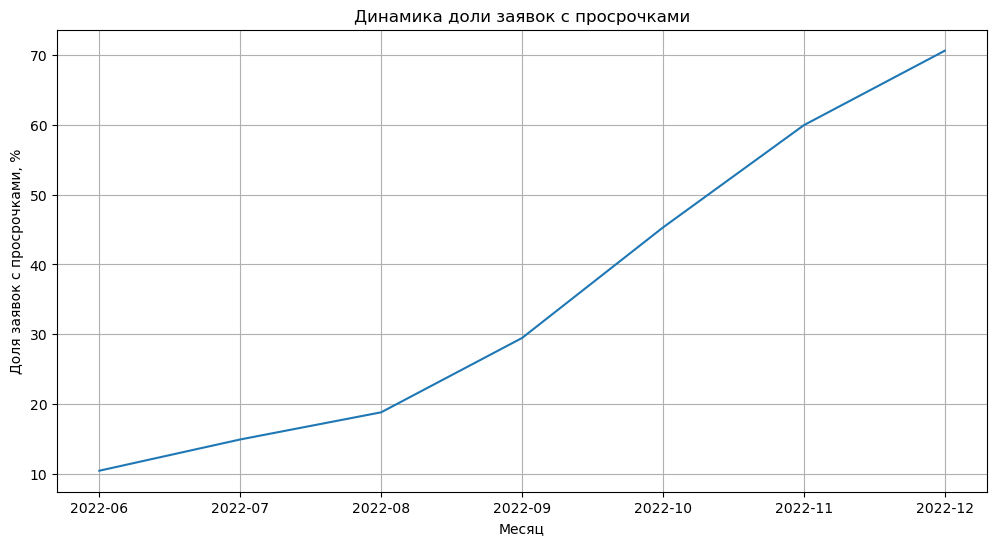

In [11]:
# Анализ динамики просрочек во времени
df['paid_month'] = df['paid_at'].dt.strftime('%Y-%m')
late_orders_by_month = df.groupby('paid_month')['is_late'].apply(lambda x: (x == '1').sum() / len(x) * 100)

# Построение графика
plt.figure(figsize=(12, 6))
late_orders_by_month.plot()
plt.title('Динамика доли заявок с просрочками')
plt.xlabel('Месяц')
plt.ylabel('Доля заявок с просрочками, %')
plt.grid()
plt.show()


Наблюдается тревожная тенденция, когда доля просроченных заявок демонстрирует линейный рост с 10% в середине года до 70% к концу года. Такая динамика указывает на наличие серьезных системных проблем, требующих пристального внимания и принятия незамедлительных мер.

Высокий и стабильный рост просрочек свидетельствует о глубинных трудностях в организации процессов обслуживания заказов или работы с дебиторской задолженностью. 

Только детальное изучение внутренних механизмов, лежащих в основе растущей доли просроченных платежей, может помочь разработать эффективные стратегии по исправлению ситуации и восстановлению надлежащего уровня платежной дисциплины. Своевременное принятие корректирующих мер критически важно для предотвращения дальнейшего ухудшения ситуации.

### Корреляция характеристик заказов с вероятностью просрочек

In [12]:
# Вычисляем количество дней просрочки
df.loc[:, 'days_late'] = (df['paid_at'] - df['plan_at']).dt.days
df.loc[:, 'is_late'] = (df['days_late'] > 0).astype(int)

# Вычисляем количество дней, в течение которых заявка был открыт
df.loc[:, 'days_open'] = (df['closed_at'] - df['created_at']).dt.days

# Добавляем столбец 'paid_month'
df.loc[:, 'paid_month'] = df['paid_at'].dt.strftime('%Y-%m')

# Анализ связи характеристик заявок с вероятностью просрочек
print("Корреляция характеристик заявок с вероятностью просрочек:")
print(df[['issued_sum', 'days_open', 'days_late', 'is_late']].corr())


Корреляция характеристик заявок с вероятностью просрочек:
            issued_sum  days_open  days_late   is_late
issued_sum    1.000000   0.075387   0.018280  0.017174
days_open     0.075387   1.000000   0.287135  0.258216
days_late     0.018280   0.287135   1.000000  0.712323
is_late       0.017174   0.258216   0.712323  1.000000


1. Сумма выдачи имеет незначительное влияние на вероятность и количество дней просрочки.

2. Более длительные сроки открытия заказа ассоциируются с большим количеством дней просрочки и более высокой вероятностью просрочки.

3. Чем больше дней просрочки, тем выше вероятность того, что заказ был просрочен.

Можно сделать вывод, что количество дней открытия заказа является более значимым фактором, влияющим на вероятность и количество дней просрочки, по сравнению с суммой выдачи. Заказы, открытые в течение более длительных периодов времени, имеют большую вероятность и больше дней просрочки.

### Визуализация зависимости количества дней открытия заяки относительно дней просрочки

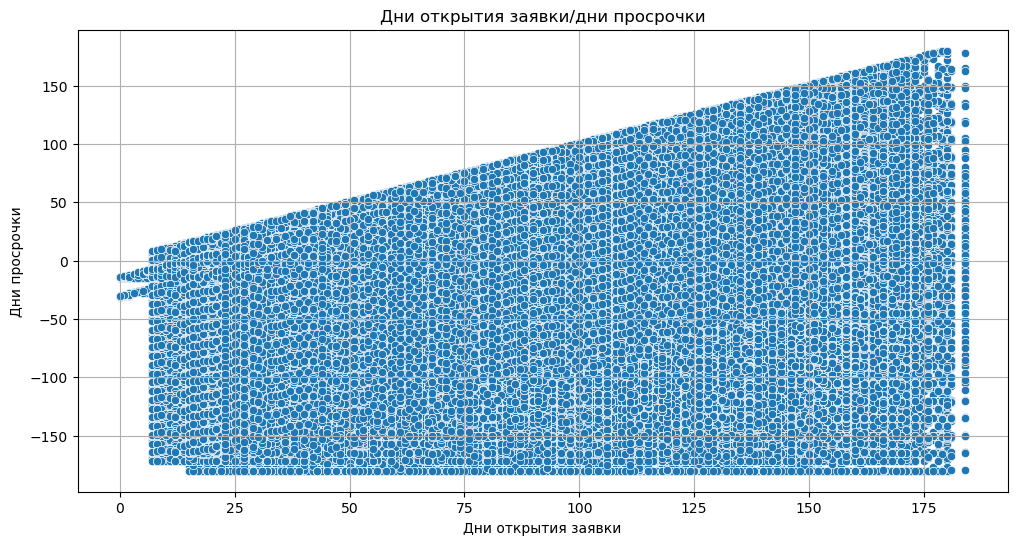

In [13]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='days_open', y='days_late', data=df)
plt.title('Дни открытия заявки/дни просрочки')
plt.xlabel('Дни открытия заявки')
plt.ylabel('Дни просрочки')
plt.grid()
plt.show()

На графике мы наблюдаем зависимость количества количества дней открытия заяки относительно дней просрочки платежа.

### Анализ динамики платежей

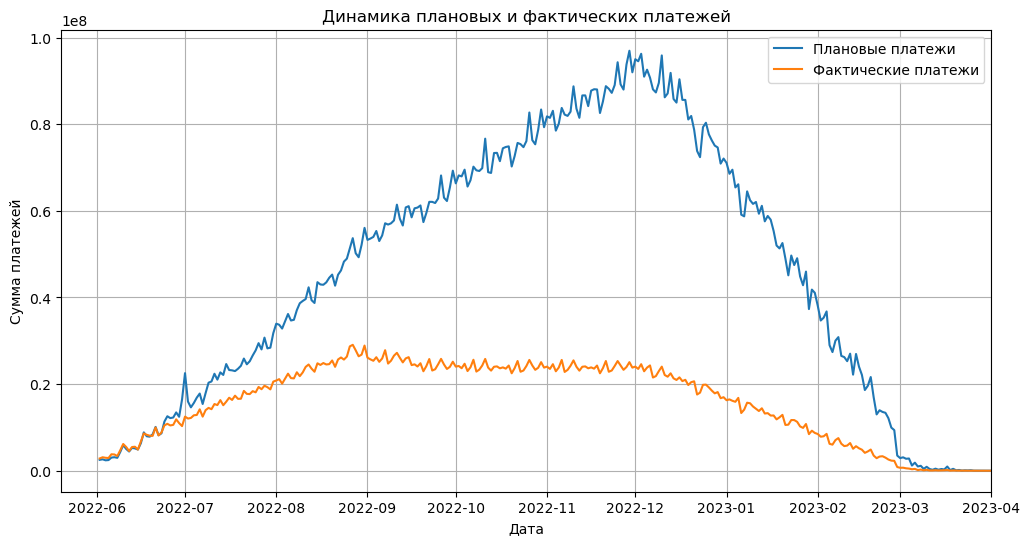

In [14]:
tmp_df = df.groupby(pd.Grouper(key='plan_at', freq='D')).agg({'plan_sum_total': 'sum', 'paid_sum': 'sum'}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(tmp_df['plan_at'], tmp_df['plan_sum_total'], label='Плановые платежи')
plt.plot(tmp_df['plan_at'], tmp_df['paid_sum'], label='Фактические платежи')
plt.title('Динамика плановых и фактических платежей')
plt.xlabel('Дата')
plt.ylabel('Сумма платежей')
plt.grid()
plt.xlim(pd.Timestamp('2022-05-20'), pd.Timestamp('2023-04-01'))
plt.legend()
plt.show()


На графике видим большие различия между плановыми и фактическими платежами с июля 2022 года по март 2023 года.

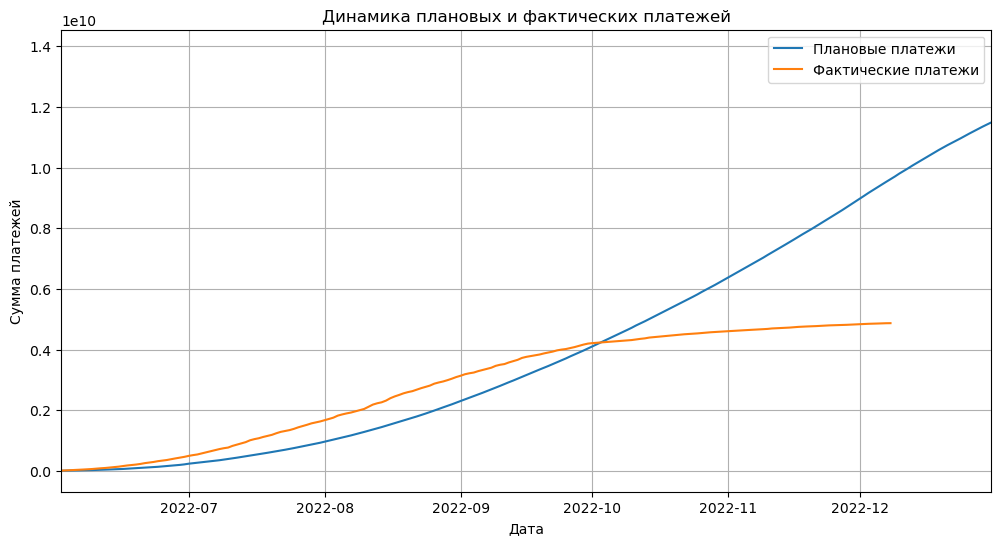

In [15]:
plan_sum_cumulative = df.groupby(pd.Grouper(key='plan_at', freq='D'))['plan_sum_total'].sum().cumsum()
paid_sum_cumulative = df.groupby(pd.Grouper(key='paid_at', freq='D'))['paid_sum'].sum().cumsum()

# График плановых и фактических платежей
plt.figure(figsize=(12, 6))
plt.plot(plan_sum_cumulative.index, plan_sum_cumulative, label='Плановые платежи')
plt.plot(paid_sum_cumulative.index, paid_sum_cumulative, label='Фактические платежи')
plt.title('Динамика плановых и фактических платежей')
plt.xlabel('Дата')
plt.ylabel('Сумма платежей')
plt.grid()
plt.xlim(plan_sum_cumulative.index.min(), pd.to_datetime('2022-12-31'))
plt.legend()
plt.show()

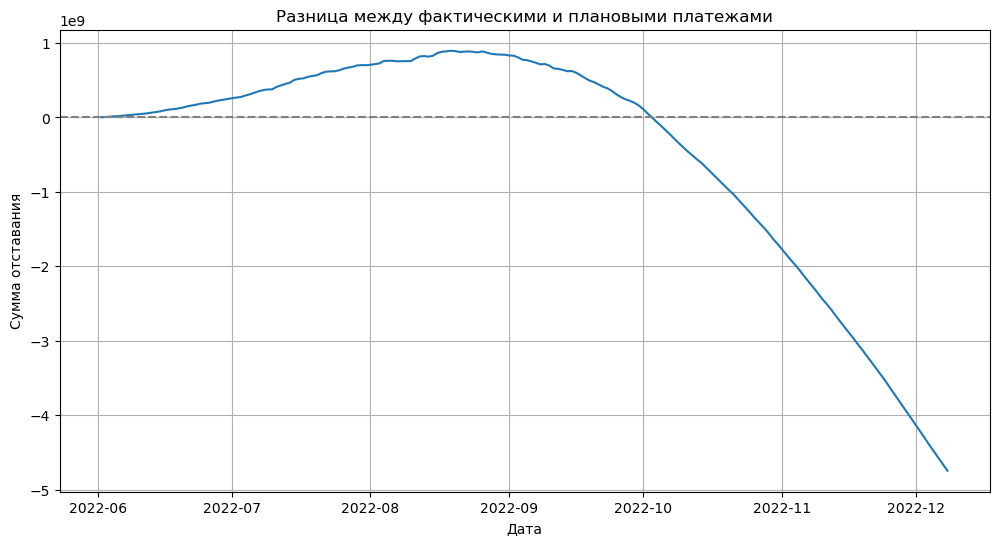

In [16]:
# Анализ соотношения плановых и фактических платежей
payment_delay =  paid_sum_cumulative - plan_sum_cumulative

plt.figure(figsize=(12, 6))
plt.plot(plan_sum_cumulative.index, payment_delay)
plt.axhline(y=0, color='grey', linestyle='--')  
plt.title('Разница между фактическими и плановыми платежами')
plt.xlabel('Дата')
plt.ylabel('Сумма отставания')
plt.grid()
plt.show()

In [17]:
payment_delay_by_month = (paid_sum_cumulative - plan_sum_cumulative).groupby(pd.Grouper(freq='M')).apply(lambda x: x[-1] - x[0])

result = pd.DataFrame({'month': payment_delay_by_month.index.strftime('%Y-%m'), 'payment_delay': payment_delay_by_month.values})
display(result[~result['payment_delay'].isna()])

,month,payment_delay
0,2022-06,2.449800e+08
1,2022-07,4.445528e+08
2,2022-08,1.349426e+08
3,2022-09,-6.727333e+08
4,2022-10,-1.809864e+09
5,2022-11,-2.281457e+09


В период с июня 2022 года по август 2022 года фактические платежи превышали плановые, что отражается в положительных значениях "payment_delay". Это означает, что в эти месяцы компания отработала лучше, чем планировалось.

Начиная с сентября 2022 года, "payment_delay" становится отрицательным, что говорит о том, что фактические платежи стали отставать от плановых. Наблюдается постепенное увеличение отставания с сентября по ноябрь 2022 года.



### Выводы

Характер поведения клиентов с точки зрения просрочки платежей:
   - Доля просроченных платежей составляет значительную часть от общего числа платежей, что свидетельствует о наличии проблем с погашением обязательств клиентами.
   - Средняя длительность просрочки составляет 35 дней, что негативно отражается на финансовом состоянии компании и требует пристального внимания.
   - Анализ динамики просрочек по месяцам показывает тенденцию к увеличению разницы между фактическими и плановыми платежами, что указывает на необходимость разработки и внедрения мер по управлению этим показателем.


Рекомендации по управлению просрочками:
   - Необходимо провести более глубокий анализ причин возникновения просрочек, включая исследование по различным сегментам клиентов, регионам и продуктам. Это позволит выявить ключевые факторы, влияющие на уровень просрочки, и разработать адресные меры воздействия.
   - Следует разработать и внедрить комплексную программу мероприятий по снижению уровня просрочки. Это может включать совершенствование процессов оценки кредитоспособности, мониторинга заемщиков, а также внедрение более эффективных методов взыскания задолженности.
   - Важно внедрить регулярный мониторинг ключевых показателей просрочки, что позволит своевременно реагировать на изменения ситуации и принимать необходимые корректирующие меры.